<a href="https://colab.research.google.com/github/ShuichiroTsuda/Kaggle_Predict_Future_Sales/blob/master/Predict_Future_Sales2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download Datasets

In [2]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
import time

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/root/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)


Download 100%.


In [3]:
!kaggle competitions download -c competitive-data-science-predict-future-sales

  0% 0.00/13.3M [00:00<?, ?B/s]
100% 13.3M/13.3M [00:00<00:00, 123MB/s]
  0% 0.00/468k [00:00<?, ?B/s]
100% 468k/468k [00:00<00:00, 152MB/s]
  0% 0.00/3.49k [00:00<?, ?B/s]
100% 3.49k/3.49k [00:00<00:00, 3.40MB/s]
  0% 0.00/1.02M [00:00<?, ?B/s]
100% 1.02M/1.02M [00:00<00:00, 145MB/s]
  0% 0.00/2.91k [00:00<?, ?B/s]
100% 2.91k/2.91k [00:00<00:00, 2.91MB/s]
  0% 0.00/368k [00:00<?, ?B/s]
100% 368k/368k [00:00<00:00, 119MB/s]


In [4]:
!unzip items.csv.zip 
!unzip sample_submission.csv.zip 
!unzip sales_train.csv.zip
!unzip test.csv.zip

Archive:  items.csv.zip
  inflating: items.csv               
Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   
Archive:  sales_train.csv.zip
  inflating: sales_train.csv         
Archive:  test.csv.zip
  inflating: test.csv                


## Dependencies

In [5]:
!pip install catboost

     |████████████████████████████████| 64.4MB 47kB/s 


In [0]:
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import catboost
from catboost import Pool
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

%matplotlib inline
sns.set(style="darkgrid")
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings("ignore")

## Loading Data

In [0]:
test = pd.read_csv('test.csv', 
                   dtype={'ID': 'int32', 'shop_id': 'int32', 'item_id': 'int32'})
item_categories = pd.read_csv('item_categories.csv', 
                              dtype={'item_category_name': 'str', 'item_category_id': 'int32'})
items = pd.read_csv('items.csv', 
                    dtype={'item_name': 'str', 'item_id': 'int32','item_category_id': 'int32'})
shops = pd.read_csv('shops.csv', 
                    dtype={'shop_name': 'str', 'shop_id': 'int32'})
sales = pd.read_csv('sales_train.csv', 
                    parse_dates=['date'], 
                    dtype={'date': 'str', 'date_block_num': 'int32', 'shop_id': 'int32', 'item_id': 'int32', 'item_price': 'float32', 'item_cnt_day': 'int32'})

In [8]:
print(test.head())

   ID  shop_id  item_id
0   0        5     5037
1   1        5     5320
2   2        5     5233
3   3        5     5232
4   4        5     5268


In [9]:
print(item_categories.head())

        item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1
2         Аксессуары - PS3                 2
3         Аксессуары - PS4                 3
4         Аксессуары - PSP                 4


In [10]:
print(items.head())

                                           item_name  item_id  item_category_id
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0                40
1  !ABBYY FineReader 12 Professional Edition Full...        1                76
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2                40
3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3                40
4        ***КОРОБКА (СТЕКЛО)                       D        4                40


In [11]:
print(shops.head())

                        shop_name  shop_id
0   !Якутск Орджоникидзе, 56 фран        0
1   !Якутск ТЦ "Центральный" фран        1
2                Адыгея ТЦ "Мега"        2
3  Балашиха ТРК "Октябрь-Киномир"        3
4        Волжский ТЦ "Волга Молл"        4


In [12]:
print(sales.head())

        date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0 2013-02-01               0       59    22154      999.00             1
1 2013-03-01               0       25     2552      899.00             1
2 2013-05-01               0       25     2552      899.00            -1
3 2013-06-01               0       25     2554     1709.05             1
4 2013-01-15               0       25     2555     1099.00             1


## Join Datasets

In [0]:
train = sales.join(items, on='item_id', rsuffix='_').join(shops, on='shop_id', rsuffix='_').join(item_categories, on='item_category_id', rsuffix='_').drop(['item_id_', 'shop_id_', 'item_category_id_'], axis=1)

In [14]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name
0,2013-02-01,0,59,22154,999.00,1,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray
1,2013-03-01,0,25,2552,899.00,1,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
2,2013-05-01,0,25,2552,899.00,-1,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
3,2013-06-01,0,25,2554,1709.05,1,DEEP PURPLE Who Do You Think We Are LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
4,2013-01-15,0,25,2555,1099.00,1,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,"Москва ТРК ""Атриум""",Музыка - CD фирменного производства


In [15]:
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00
mean,14.57,33.00,10197.23,890.62,1.24,40.00
std,9.42,16.23,6324.30,1726.44,2.62,17.10
min,0.00,0.00,0.00,-1.00,-22.00,0.00
25%,7.00,22.00,4476.00,249.00,1.00,28.00
50%,14.00,31.00,9343.00,399.00,1.00,40.00
75%,23.00,47.00,15684.00,999.00,1.00,55.00
max,33.00,59.00,22169.00,307980.00,2169.00,83.00


## Time Period

In [16]:
print('Min date from train set: %s' % train['date'].min().date())
print('Max date from train set: %s' % train['date'].max().date())

Min date from train set: 2013-01-01
Max date from train set: 2015-12-10


## Data Leakages
I use only the "shop_id" and "item_id" that appear on the test set.

In [0]:
test_shop_ids = test['shop_id'].unique()
test_item_ids = test['item_id'].unique()

lk_train = train[train['shop_id'].isin(test_shop_ids)]
lk_train = lk_train[lk_train['item_id'].isin(test_item_ids)]

In [18]:
print('Data set size before leaking:', train.shape[0])
print('Data set size after leaking:', lk_train.shape[0])

Data set size before leaking: 2935849
Data set size after leaking: 1224439


## Data Preprocesssing
I dropped 
- the data with "item_price <= 0".
- the text features.

I aggregate the data by month.

In [0]:
train = train.query('item_price > 0')

In [0]:
train_monthly = lk_train[['date', 'date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'item_cnt_day']]

In [0]:
train_monthly = train_monthly.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_category_id', 'item_id'], as_index=False)
train_monthly = train_monthly.agg({'item_price':['sum', 'mean'], 'item_cnt_day':['sum', 'mean','count']})
train_monthly.columns = ['date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'mean_item_price', 'item_cnt', 'mean_item_cnt', 'transactions']

In [0]:
# Build a data set with all the possible combinations of ['date_block_num','shop_id','item_id'] so we won't have missing records.
shop_ids = train_monthly['shop_id'].unique()
item_ids = train_monthly['item_id'].unique()
empty_df = []
for i in range(34):
    for shop in shop_ids:
        for item in item_ids:
            empty_df.append([i, shop, item])
    
empty_df = pd.DataFrame(empty_df, columns=['date_block_num','shop_id','item_id'])

# Merge the train set with the complete set (missing records will be filled with 0).
train_monthly = pd.merge(empty_df, train_monthly, on=['date_block_num','shop_id','item_id'], how='left')
train_monthly.fillna(0, inplace=True)


In [0]:
# Merge the train set with the complete set (missing records will be filled with 0).
train_monthly = pd.merge(empty_df, train_monthly, on=['date_block_num','shop_id','item_id'], how='left')
train_monthly.fillna(0, inplace=True)

In [0]:
# Extract time based features.
train_monthly['year'] = train_monthly['date_block_num'].apply(lambda x: ((x//12) + 2013))
train_monthly['month'] = train_monthly['date_block_num'].apply(lambda x: (x % 12))

## Show Current Dataset

In [25]:
print(train_monthly.head().T)
print(train_monthly.describe().T)

                        0       1       2       3       4
date_block_num       0.00    0.00    0.00    0.00    0.00
shop_id              2.00    2.00    2.00    2.00    2.00
item_id           5572.00 5643.00 5583.00 7893.00 7894.00
item_category_id     2.00    2.00    5.00    6.00    6.00
item_price       10730.00 4775.21 1188.30 5970.00 1490.00
mean_item_price   1532.86 2387.60  594.15 1990.00 1490.00
item_cnt             9.00    0.00    2.00    3.00    1.00
mean_item_cnt        1.29    0.00    1.00    1.00    1.00
transactions         7.00    2.00    2.00    3.00    1.00
year              2013.00 2013.00 2013.00 2013.00 2013.00
month                0.00    0.00    0.00    0.00    0.00
                      count     mean     std  ...      50%      75%       max
date_block_num   6734448.00    16.50    9.81  ...    16.50    25.00     33.00
shop_id          6734448.00    31.64   17.56  ...    34.50    47.00     59.00
item_id          6734448.00 11041.89 6210.74  ... 11265.50 16068.25  2

## EDA

In [0]:
# Grouping data for EDA.
gp_month_mean = train_monthly.groupby(['month'], as_index=False)['item_cnt'].mean()
gp_month_sum = train_monthly.groupby(['month'], as_index=False)['item_cnt'].sum()
gp_category_mean = train_monthly.groupby(['item_category_id'], as_index=False)['item_cnt'].mean()
gp_category_sum = train_monthly.groupby(['item_category_id'], as_index=False)['item_cnt'].sum()
gp_shop_mean = train_monthly.groupby(['shop_id'], as_index=False)['item_cnt'].mean()
gp_shop_sum = train_monthly.groupby(['shop_id'], as_index=False)['item_cnt'].sum()

### The behavior of sales along the year

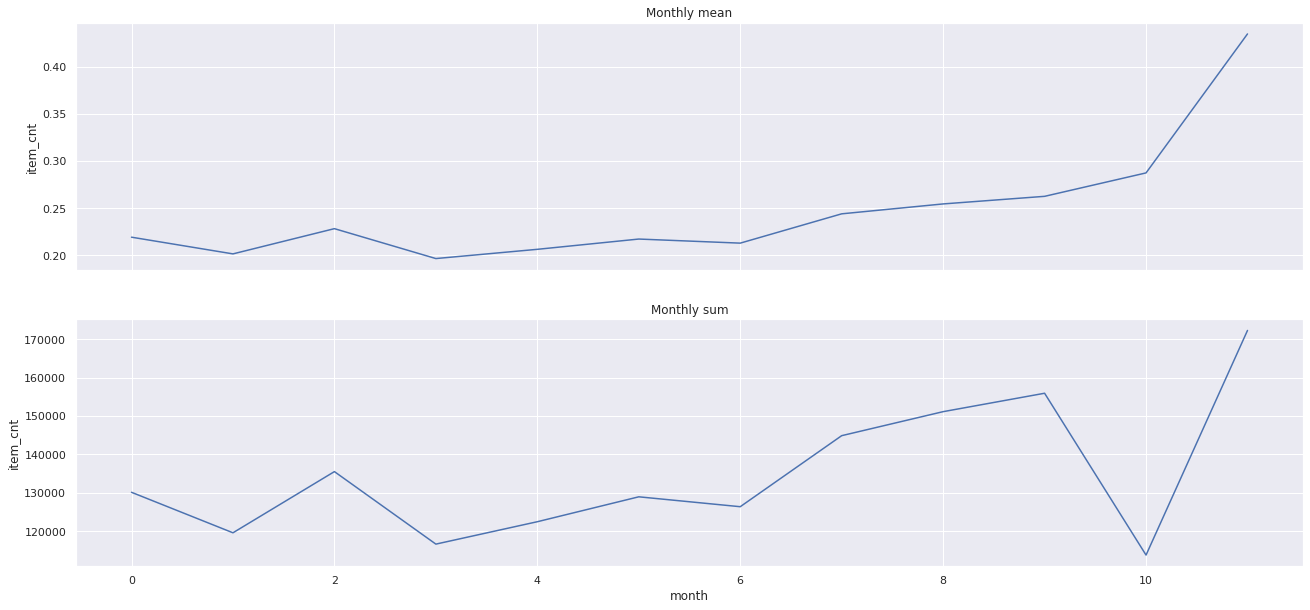

In [27]:
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.lineplot(x="month", y="item_cnt", data=gp_month_mean, ax=axes[0]).set_title("Monthly mean")
sns.lineplot(x="month", y="item_cnt", data=gp_month_sum, ax=axes[1]).set_title("Monthly sum")
plt.show()

### The amount of sales in regard to every category

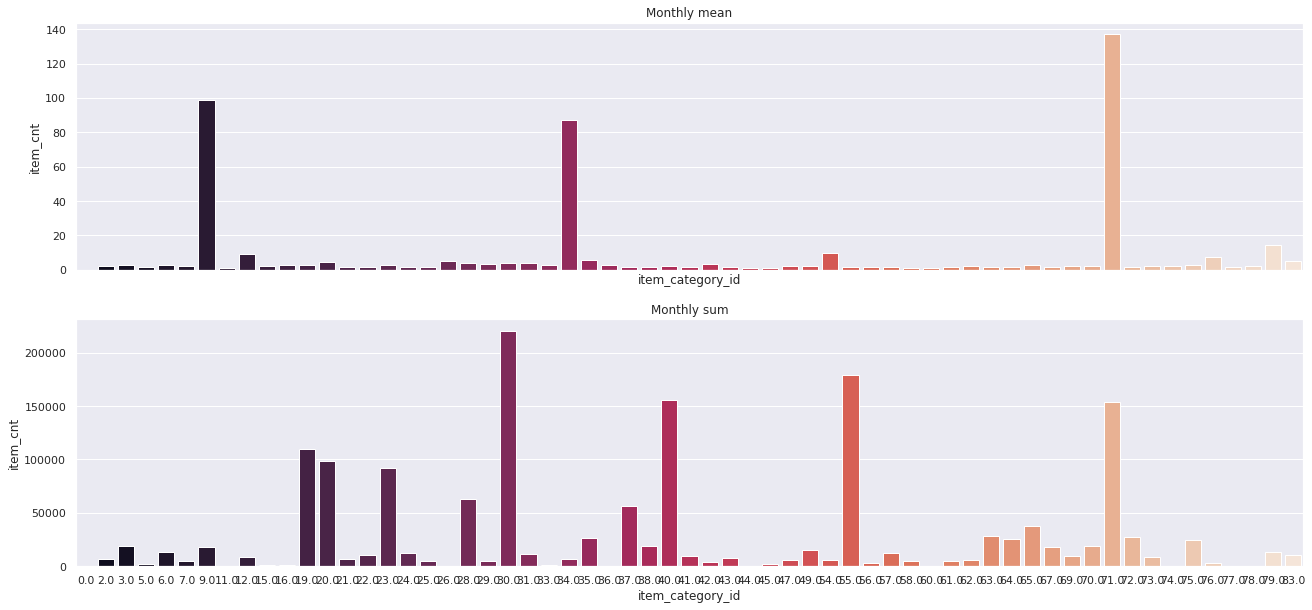

In [28]:
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="item_category_id", y="item_cnt", data=gp_category_mean, ax=axes[0], palette="rocket").set_title("Monthly mean")
sns.barplot(x="item_category_id", y="item_cnt", data=gp_category_sum, ax=axes[1], palette="rocket").set_title("Monthly sum")
plt.show()

## Checking for Outliers

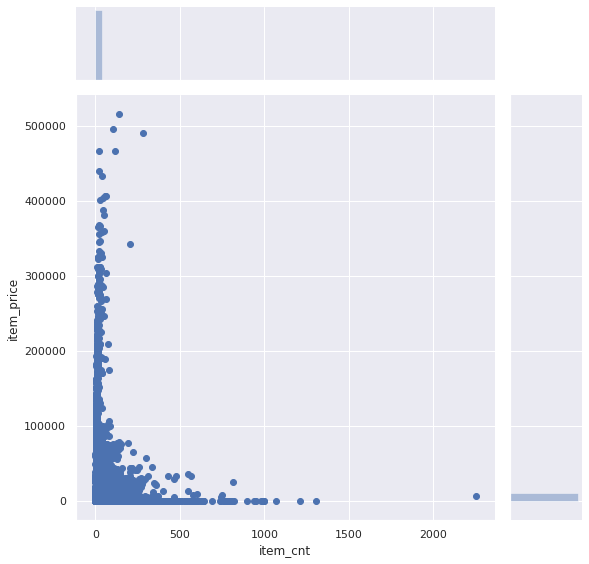

In [29]:
sns.jointplot(x="item_cnt", y="item_price", data=train_monthly, height=8)
plt.show()

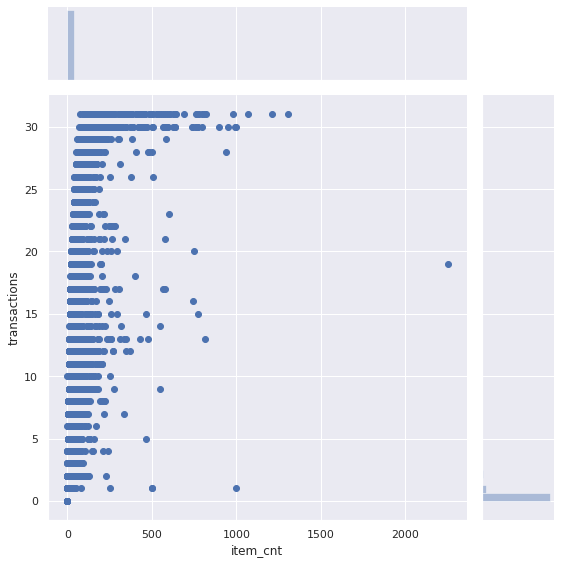

In [30]:
sns.jointplot(x="item_cnt", y="transactions", data=train_monthly, height=8)
plt.show()

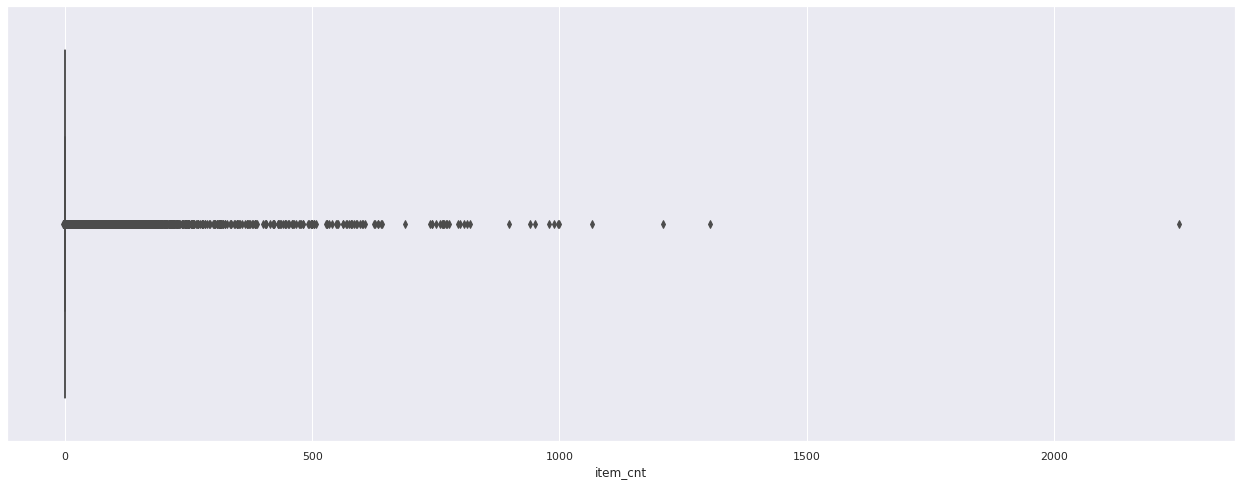

In [31]:
plt.subplots(figsize=(22, 8))
sns.boxplot(train_monthly["item_cnt"])
plt.show()

### Removing outliers

I'll treat "item_cnt" > 20 and < 0, "item_price" >= 400000 as outliers, so I'll remove them.



In [0]:
train_monthly = train_monthly.query('item_cnt >= 0 and item_cnt <= 20 and item_price < 40000')

## Create the label

In [0]:
train_monthly["item_cnt_month"] = train_monthly.sort_values("date_block_num").groupby(['shop_id', 'item_id'])['item_cnt'].shift(-1)

In [34]:
train_monthly.head()

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month,item_cnt_month
0,0,2,5572,2.00,10730.00,1532.86,9.00,1.29,7.00,2013,0,1.00
1,0,2,5643,2.00,4775.21,2387.60,0.00,0.00,2.00,2013,0,0.00
2,0,2,5583,5.00,1188.30,594.15,2.00,1.00,2.00,2013,0,1.00
3,0,2,7893,6.00,5970.00,1990.00,3.00,1.00,3.00,2013,0,2.00
4,0,2,7894,6.00,1490.00,1490.00,1.00,1.00,1.00,2013,0,2.00


## Feature Engineering

### Unitary item pirces

In [0]:
train_monthly["item_price_unit"] = train_monthly['item_price'] // train_monthly["item_cnt"]
train_monthly['item_price_unit'].fillna(0, inplace=True)

### Group based features

In [0]:
gp_item_price = train_monthly.sort_values('date_block_num').groupby(['item_id'], as_index=False).agg({'item_price':[np.min, np.max]})
gp_item_price.columns = ['item_id', 'hist_min_item_price', 'hist_max_item_price']

train_monthly = pd.merge(train_monthly, gp_item_price, on='item_id', how='left')


### How much each item's price changed from its (lowest/highest) historical price.

In [0]:
train_monthly['price_increase'] = train_monthly['item_price'] - train_monthly['hist_min_item_price']
train_monthly['price_decrease'] = train_monthly['hist_max_item_price'] - train_monthly['item_price']

### Rolling window based features (window = 3 months)

In [0]:
# Min value
f_min = lambda x: x.rolling(window=3, min_periods=1).min()
# Max value
f_max = lambda x: x.rolling(window=3, min_periods=1).max()
# Mean value
f_mean = lambda x: x.rolling(window=3, min_periods=1).mean()
# Standard deviation
f_std = lambda x: x.rolling(window=3, min_periods=1).std()

function_list = [f_min, f_max, f_mean, f_std]
function_name = ['min', 'max', 'mean', 'std']

for i in range(len(function_list)):
    train_monthly[('item_cnt_%s' % function_name[i])] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_category_id', 'item_id'])['item_cnt'].apply(function_list[i])

# Fill the empty std features with 0
train_monthly['item_cnt_std'].fillna(0, inplace=True)

### Lag Based features

In [0]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [0]:
train_monthly = lag_feature(train_monthly, [1,2,3], 'item_cnt_month')

In [0]:
group = train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

train_monthly = pd.merge(train_monthly, group, on=['item_id'], how='left')
train_monthly['item_avg_item_price'] = train_monthly['item_avg_item_price'].astype(np.float16)

group = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

train_monthly = pd.merge(train_monthly, group, on=['date_block_num','item_id'], how='left')
train_monthly['date_item_avg_item_price'] = train_monthly['date_item_avg_item_price'].astype(np.float16)
lags = [1,2,3]
train_monthly = lag_feature(train_monthly, lags, 'date_item_avg_item_price')

for i in lags:
    train_monthly['delta_price_lag_'+str(i)] = \
        (train_monthly['date_item_avg_item_price_lag_'+str(i)] - train_monthly['item_avg_item_price']) / train_monthly['item_avg_item_price']

def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0
    
train_monthly['delta_price_lag'] = train_monthly.apply(select_trend, axis=1)
train_monthly['delta_price_lag'] = train_monthly['delta_price_lag'].astype(np.float16)
train_monthly['delta_price_lag'].fillna(0, inplace=True)

fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

train_monthly.drop(fetures_to_drop, axis=1, inplace=True)

### Dataset after feature engineering

In [42]:
print(train_monthly.head().T)
print(train_monthly.describe().T)

                            0        1       2        3        4
date_block_num           0.00     0.00    0.00     0.00     0.00
shop_id                  2.00     2.00    2.00     2.00     2.00
item_id               5572.00  5643.00 5583.00  7893.00  7894.00
item_category_id         2.00     2.00    5.00     6.00     6.00
item_price           10730.00  4775.21 1188.30  5970.00  1490.00
mean_item_price       1532.86  2387.60  594.15  1990.00  1490.00
item_cnt                 9.00     0.00    2.00     3.00     1.00
mean_item_cnt            1.29     0.00    1.00     1.00     1.00
transactions             7.00     2.00    2.00     3.00     1.00
year                  2013.00  2013.00 2013.00  2013.00  2013.00
month                    0.00     0.00    0.00     0.00     0.00
item_cnt_month           1.00     0.00    1.00     2.00     2.00
item_price_unit       1192.00      inf  594.00  1990.00  1490.00
hist_min_item_price      0.00     0.00    0.00     0.00     0.00
hist_max_item_price  1897

## Train/Validation split

In [43]:
train_set = train_monthly.query('date_block_num >= 3 and date_block_num < 28').copy()
validation_set = train_monthly.query('date_block_num >= 28 and date_block_num < 33').copy()
test_set = train_monthly.query('date_block_num == 33').copy()

train_set.dropna(subset=['item_cnt_month'], inplace=True)
validation_set.dropna(subset=['item_cnt_month'], inplace=True)

train_set.dropna(inplace=True)
validation_set.dropna(inplace=True)

print('Train set records:', train_set.shape[0])
print('Validation set records:', validation_set.shape[0])
print('Test set records:', test_set.shape[0])

print('Train set records: %s (%.f%% of complete data)' % (train_set.shape[0], ((train_set.shape[0]/train_monthly.shape[0])*100)))
print('Validation set records: %s (%.f%% of complete data)' % (validation_set.shape[0], ((validation_set.shape[0]/train_monthly.shape[0])*100)))

Train set records: 4938031
Validation set records: 987350
Test set records: 197810
Train set records: 4938031 (73% of complete data)
Validation set records: 987350 (15% of complete data)


## Mean Encoding




In [0]:
# Shop mean encoding.
gp_shop_mean = train_set.groupby(['shop_id']).agg({'item_cnt_month': ['mean']})
gp_shop_mean.columns = ['shop_mean']
gp_shop_mean.reset_index(inplace=True)
# Item mean encoding.
gp_item_mean = train_set.groupby(['item_id']).agg({'item_cnt_month': ['mean']})
gp_item_mean.columns = ['item_mean']
gp_item_mean.reset_index(inplace=True)
# Shop with item mean encoding.
gp_shop_item_mean = train_set.groupby(['shop_id', 'item_id']).agg({'item_cnt_month': ['mean']})
gp_shop_item_mean.columns = ['shop_item_mean']
gp_shop_item_mean.reset_index(inplace=True)
# Year mean encoding.
gp_year_mean = train_set.groupby(['year']).agg({'item_cnt_month': ['mean']})
gp_year_mean.columns = ['year_mean']
gp_year_mean.reset_index(inplace=True)
# Month mean encoding.
gp_month_mean = train_set.groupby(['month']).agg({'item_cnt_month': ['mean']})
gp_month_mean.columns = ['month_mean']
gp_month_mean.reset_index(inplace=True)

# Add meand encoding features to train set.
train_set = pd.merge(train_set, gp_shop_mean, on=['shop_id'], how='left')
train_set = pd.merge(train_set, gp_item_mean, on=['item_id'], how='left')
train_set = pd.merge(train_set, gp_shop_item_mean, on=['shop_id', 'item_id'], how='left')
train_set = pd.merge(train_set, gp_year_mean, on=['year'], how='left')
train_set = pd.merge(train_set, gp_month_mean, on=['month'], how='left')
# Add meand encoding features to validation set.
validation_set = pd.merge(validation_set, gp_shop_mean, on=['shop_id'], how='left')
validation_set = pd.merge(validation_set, gp_item_mean, on=['item_id'], how='left')
validation_set = pd.merge(validation_set, gp_shop_item_mean, on=['shop_id', 'item_id'], how='left')
validation_set = pd.merge(validation_set, gp_year_mean, on=['year'], how='left')
validation_set = pd.merge(validation_set, gp_month_mean, on=['month'], how='left')

In [0]:
# Create train and validation sets and labels. 
X_train = train_set.drop(['item_cnt_month', 'date_block_num'], axis=1)
Y_train = train_set['item_cnt_month'].astype(int)
X_validation = validation_set.drop(['item_cnt_month', 'date_block_num'], axis=1)
Y_validation = validation_set['item_cnt_month'].astype(int)

In [0]:
# Integer features (used by catboost model).
int_features = ['shop_id', 'item_id', 'year', 'month']

X_train[int_features] = X_train[int_features].astype('int32')
X_validation[int_features] = X_validation[int_features].astype('int32')

## Build Test Set
I want to  predict for "date_block_num" 34 so our test set will be block 33 and our predictions should reflect block 34 values. 

In [0]:
latest_records = pd.concat([train_set, validation_set]).drop_duplicates(subset=['shop_id', 'item_id'], keep='last')
X_test = pd.merge(test, latest_records, on=['shop_id', 'item_id'], how='left', suffixes=['', '_'])
X_test['year'] = 2015
X_test['month'] = 9
X_test.drop('item_cnt_month', axis=1, inplace=True)
X_test[int_features] = X_test[int_features].astype('int32')
X_test = X_test[X_train.columns]

## Replacing Missing Values

In [0]:
sets = [X_train, X_validation, X_test]

# Replace missing values with the median of each shop.            
for dataset in sets:
    for shop_id in dataset['shop_id'].unique():
        for column in dataset.columns:
            shop_median = dataset[(dataset['shop_id'] == shop_id)][column].median()
            dataset.loc[(dataset[column].isnull()) & (dataset['shop_id'] == shop_id), column] = shop_median
            
# Fill remaining missing values on test set with mean.
X_test.fillna(X_test.mean(), inplace=True)

In [0]:
# I'm dropping "item_category_id", we don't have it on test set and would be a little hard to create categories for items that exist only on test set.
X_train.drop(['item_category_id'], axis=1, inplace=True)
X_validation.drop(['item_category_id'], axis=1, inplace=True)
X_test.drop(['item_category_id'], axis=1, inplace=True)

In [0]:
X_train[int_features] = X_train[int_features].astype('int32')
X_validation[int_features] = X_validation[int_features].astype('int32')
X_test[int_features] = X_test[int_features].astype('int32')
X_test = X_test[X_train.columns]

## Test Set

In [51]:
print(X_test.head().T)
print(X_test.describe().T)

                            0       1       2       3       4
shop_id                  5.00    5.00    5.00    5.00    5.00
item_id               5037.00 5320.00 5233.00 5232.00 5268.00
item_price             749.50    0.00 2997.00    0.00    0.00
mean_item_price        749.50    0.00  999.00    0.00    0.00
item_cnt                 1.00    0.00    3.00    0.00    0.00
mean_item_cnt            1.00    0.00    1.00    0.00    0.00
transactions             1.00    0.00    3.00    0.00    0.00
year                  2015.00 2015.00 2015.00 2015.00 2015.00
month                    9.00    9.00    9.00    9.00    9.00
item_price_unit        749.00    0.00  999.00    0.00    0.00
hist_min_item_price      0.00    0.00    0.00    0.00    0.00
hist_max_item_price  25990.00 2428.81 7191.75 4796.00 2428.81
price_increase         749.50    0.00 2997.00    0.00    0.00
price_decrease       25240.50 2394.00 4194.75 4796.00 2394.00
item_cnt_min             1.00    0.00    1.00    0.00    0.00
item_cnt

## Modeling the Data

### Tree Based Models

#### Catboost

In [52]:
cat_features = [0, 1, 7, 8]

catboost_model = CatBoostRegressor(
    iterations=500,
    max_ctr_complexity=4,
    random_seed=0,
    od_type='Iter',
    od_wait=25,
    verbose=50,
    depth=10,
)

catboost_model.fit(
    X_train, Y_train,
    cat_features=cat_features,
    eval_set=(X_validation, Y_validation)
)

Learning rate set to 0.354088
0:	learn: 0.7708127	test: 0.8264461	best: 0.8264461 (0)	total: 3.22s	remaining: 26m 48s
Stopped by overfitting detector  (25 iterations wait)

bestTest = 0.7816923432
bestIteration = 8

Shrink model to first 9 iterations.


#### Catboost Feature Importance

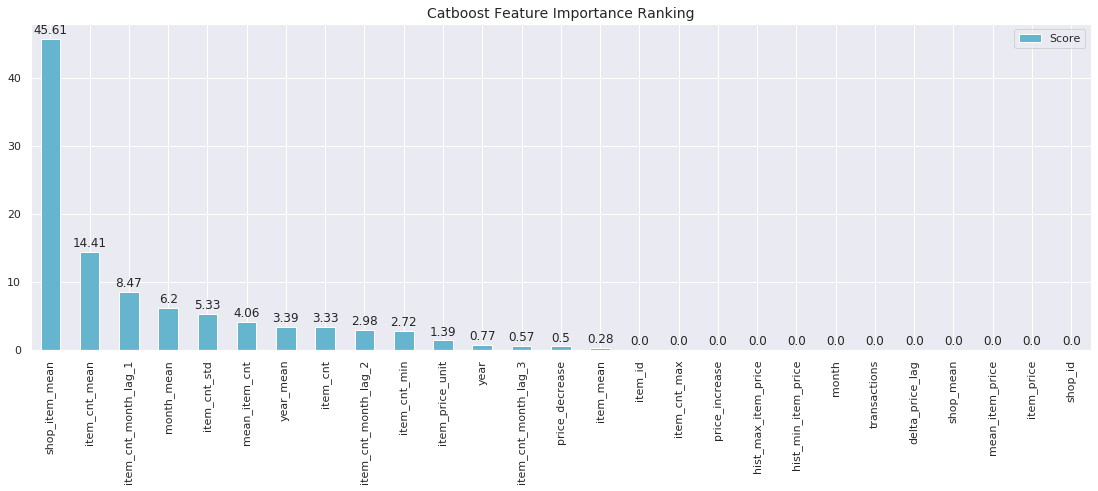

In [53]:
feature_score = pd.DataFrame(list(zip(X_train.dtypes.index, catboost_model.get_feature_importance(Pool(X_train, label=Y_train, cat_features=cat_features)))), columns=['Feature','Score'])
feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

plt.rcParams["figure.figsize"] = (19, 6)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')
rects = ax.patches
labels = feature_score['Score'].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()

In [0]:
catboost_train_pred = catboost_model.predict(X_train)
catboost_val_pred = catboost_model.predict(X_validation)
catboost_test_pred = catboost_model.predict(X_test)

In [55]:
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, catboost_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, catboost_val_pred)))

Train rmse: 0.6495416121386663
Validation rmse: 0.7816923431689655


In [56]:
X_train.columns

Index(['shop_id', 'item_id', 'item_price', 'mean_item_price', 'item_cnt',
       'mean_item_cnt', 'transactions', 'year', 'month', 'item_price_unit',
       'hist_min_item_price', 'hist_max_item_price', 'price_increase',
       'price_decrease', 'item_cnt_min', 'item_cnt_max', 'item_cnt_mean',
       'item_cnt_std', 'item_cnt_month_lag_1', 'item_cnt_month_lag_2',
       'item_cnt_month_lag_3', 'delta_price_lag', 'shop_mean', 'item_mean',
       'shop_item_mean', 'year_mean', 'month_mean'],
      dtype='object')

### XGBoost

In [57]:
# Use only part of features on XGBoost.
xgb_features = ['shop_id', 'item_id', 'item_price','item_cnt_mean', 'item_cnt_std', 'item_cnt_month_lag_1', 'item_cnt_month_lag_2',
                'item_cnt_month_lag_3', 'delta_price_lag' , 'shop_mean', 
                'shop_item_mean', 'mean_item_cnt']
xgb_train = X_train[xgb_features]
xgb_val = X_validation[xgb_features]
xgb_test = X_test[xgb_features]

xgb_model = XGBRegressor(max_depth=10, 
                         n_estimators=1000, 
                         min_child_weight=0.5,  
                         colsample_bytree=0.7, 
                         subsample=0.7, 
                         eta=0.1, 
                         seed=0)
xgb_model.fit(xgb_train, 
              Y_train, 
              eval_metric="rmse", 
              eval_set=[(xgb_train, Y_train), (xgb_val, Y_validation)], 
              verbose=20, 
              early_stopping_rounds=20)

[10:31:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:31:14] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:0.894525	validation_1-rmse:0.884389
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[20]	validation_0-rmse:0.662805	validation_1-rmse:0.76723
Stopping. Best iteration:
[18]	validation_0-rmse:0.66603	validation_1-rmse:0.76539



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, eta=0.3, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=8, min_child_weight=300, missing=None, n_estimators=500,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=None,
             subsample=0.7, verbosity=1)

#### XGboost Feature Importance

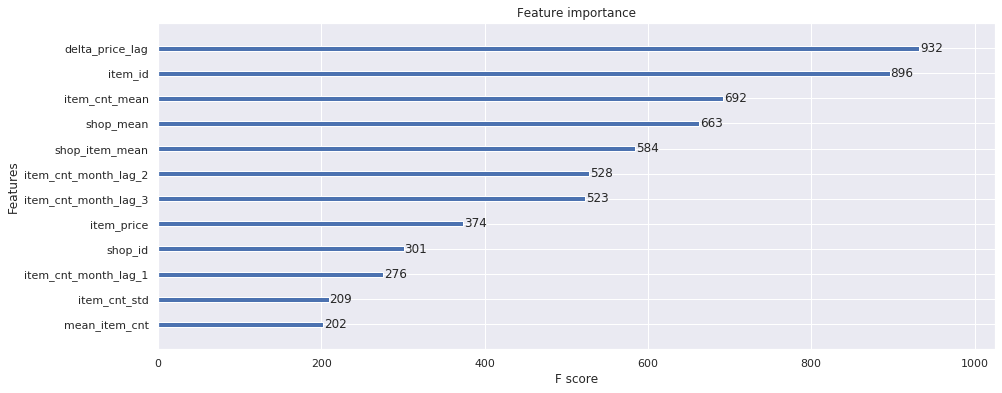

In [58]:
plt.rcParams["figure.figsize"] = (15, 6)
plot_importance(xgb_model)
plt.show()

In [59]:
xgb_train_pred = xgb_model.predict(xgb_train)
xgb_val_pred = xgb_model.predict(xgb_val)
xgb_test_pred = xgb_model.predict(xgb_test)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, xgb_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, xgb_val_pred)))

Train rmse: 0.6660299620715803
Validation rmse: 0.765389990112088


### Random Forest

In [60]:
# Use only part of features on random forest.
rf_features = ['shop_id', 'item_id', 'item_price','item_cnt_mean', 'item_cnt_std', 'item_cnt_month_lag_1', 'item_cnt_month_lag_2',
                'item_cnt_month_lag_3', 'delta_price_lag' , 'shop_mean', 
                'shop_item_mean', 'mean_item_cnt', 'month', 'year']
rf_train = X_train[rf_features]
rf_val = X_validation[rf_features]
rf_test = X_test[rf_features]

rf_model = RandomForestRegressor(n_estimators=50, max_depth=7, random_state=0, n_jobs=-1)
rf_model.fit(rf_train, Y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=7, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=-1, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [61]:
rf_train_pred = rf_model.predict(rf_train)
rf_val_pred = rf_model.predict(rf_val)
rf_test_pred = rf_model.predict(rf_test)

print('Train rmse:', np.sqrt(mean_squared_error(Y_train, rf_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, rf_val_pred)))


Train rmse: 0.6462142886350616
Validation rmse: 0.7980834127073095


### Linear Models

#### Linear Regression

In [0]:
# Use only part of features on linear Regression.
lr_features = ['item_cnt','mean_item_cnt', 'shop_mean', 'item_cnt_month_lag_1', 'delta_price_lag']
lr_train = X_train[lr_features]
lr_val = X_validation[lr_features]
lr_test = X_test[lr_features]

In [0]:
lr_scaler = MinMaxScaler()
lr_scaler.fit(lr_train)
lr_train = lr_scaler.transform(lr_train)
lr_val = lr_scaler.transform(lr_val)
lr_test = lr_scaler.transform(lr_test)

In [64]:
lr_model = LinearRegression(n_jobs=-1)
lr_model.fit(lr_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [65]:
lr_train_pred = lr_model.predict(lr_train)
lr_val_pred = lr_model.predict(lr_val)
lr_test_pred = lr_model.predict(lr_test)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lr_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, lr_val_pred)))

Train rmse: 0.7259294659514016
Validation rmse: 0.7636063609645425


### Clustering Models

KNN Regressor

In [0]:
# Use only part of features on KNN.
knn_features =  ['shop_id', 'item_id', 'item_price','item_cnt_mean', 'item_cnt_std', 'item_cnt_month_lag_1', 'item_cnt_month_lag_2',
                'item_cnt_month_lag_3', 'delta_price_lag' , 'shop_mean', 
                'shop_item_mean', 'mean_item_cnt']

# Subsample train set (using the whole data was taking too long).
X_train_sampled = X_train[:100000]
Y_train_sampled = Y_train[:100000]

knn_train = X_train_sampled[knn_features]
knn_val = X_validation[knn_features]
knn_test = X_test[knn_features]

In [0]:
knn_scaler = MinMaxScaler()
knn_scaler.fit(knn_train)
knn_train = knn_scaler.transform(knn_train)
knn_val = knn_scaler.transform(knn_val)
knn_test = knn_scaler.transform(knn_test)

In [68]:
knn_model = KNeighborsRegressor(n_neighbors=15, leaf_size=15, n_jobs=-1)
knn_model.fit(knn_train, Y_train_sampled)

KNeighborsRegressor(algorithm='auto', leaf_size=15, metric='minkowski',
                    metric_params=None, n_jobs=-1, n_neighbors=15, p=2,
                    weights='uniform')

In [69]:
knn_train_pred = knn_model.predict(knn_train)
knn_val_pred = knn_model.predict(knn_val)
knn_test_pred = knn_model.predict(knn_test)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train_sampled, knn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, knn_val_pred)))

Train rmse: 0.4682007166922229
Validation rmse: 0.7688660069315356


## Create new datasets with the predictions from first level models

In [70]:
# Dataset that will be the train set of the ensemble model.
first_level = pd.DataFrame(catboost_val_pred, columns=['catboost'])
first_level['xgbm'] = xgb_val_pred
first_level['random_forest'] = rf_val_pred
first_level['linear_regression'] = lr_val_pred
first_level['knn'] = knn_val_pred
first_level['label'] = Y_validation.values
first_level.head()

,catboost,xgbm,random_forest,linear_regression,knn,label
0,0.68,0.78,0.86,0.63,0.27,0
1,0.80,1.00,0.97,0.04,0.53,0
2,0.07,0.11,0.10,0.04,0.00,0
3,1.19,1.33,1.58,0.04,0.20,4
4,1.71,1.52,2.10,1.19,1.47,1


In [71]:
# Dataset that will be the test set of the ensemble model.
first_level_test = pd.DataFrame(catboost_test_pred, columns=['catboost'])
first_level_test['xgbm'] = xgb_test_pred
first_level_test['random_forest'] = rf_test_pred
first_level_test['linear_regression'] = lr_test_pred
first_level_test['knn'] = knn_test_pred
first_level_test.head()

,catboost,xgbm,random_forest,linear_regression,knn
0,0.41,0.66,0.50,0.65,1.33
1,0.02,0.08,0.00,0.06,0.00
2,0.37,0.33,0.15,1.77,0.80
3,0.13,0.15,0.00,0.06,0.13
4,0.02,0.08,0.00,0.06,0.00


## Ensembling

Ensemble architecture:
- 1st level
  - Catboost
  - XGBM
  - Random forest
  - Linear Regression
  - KNN
- 2nd level;
  - Linear Regression

In [0]:
meta_model = LinearRegression(n_jobs=-1)

In [73]:
# Drop label from dataset.
first_level.drop('label', axis=1, inplace=True)
meta_model.fit(first_level, Y_validation)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [74]:
ensemble_pred = meta_model.predict(first_level)
final_predictions = meta_model.predict(first_level_test)
print('Train rmse:', np.sqrt(mean_squared_error(ensemble_pred, Y_validation)))

Train rmse: 0.7395733188920554


In [75]:
prediction_df = pd.DataFrame(test['ID'], columns=['ID'])
prediction_df['item_cnt_month'] = final_predictions.clip(0., 20.)
prediction_df.to_csv('submission.csv', index=False)
prediction_df.head()

,ID,item_cnt_month
0,0,0.96
1,1,0.06
2,2,1.13
3,3,0.16
4,4,0.06


## Make Submission File

In [0]:
prediction_df.to_csv('submission.csv', index=False)

In [77]:
!kaggle competitions submit -c competitive-data-science-predict-future-sales -f submission.csv -m test

100% 5.36M/5.36M [00:00<00:00, 17.8MB/s]
Successfully submitted to Predict Future Sales

In [78]:
from google.colab import files
files.download('submission.csv')

MessageError: ignored